<a href="https://colab.research.google.com/github/mrzResearchArena/ACP/blob/master/ACP-240.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## [1]. Google Drive Initialization:

In [48]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
ls

0_FINAL_anti_peptide_model_AC240-tensorboard.ipynb
0_FINAL_anti_peptide_model_ACP740-tensorboard.ipynb
500-164.h5
544_encoded_sequences_740.npy
ACP164.npy
ACP240_labels.npy
acp240.txt
ACP-500-164.h5
ACP500.npy
ACP740_labels.npy
ACP-740-tensorboard.ipynb
acp740.txt
blosum-164.npy
blosum-240.npy
blosum-500.npy
blosum62-acp240.npy
blosum62-acp740.npy
bpf-164.npy
bpf-240.npy
bpf-500.npy
BPF_coded_ACP164_sequences.npy
BPF_coded_ACP240_sequences.npy
BPF_coded_ACP500_sequences.npy
BPF_coded_ACP740_sequences.npy
kmer_k_3_ACP240.npy
kmer_k_3_ACP740.npy
logs/
mACP-240.ipynb
mACP-740.ipynb
model-240.png
model-500-164.png
model-740.png
model.png
multichannel.png
physico_coded_ACP164_sequences.npy
physico_coded_ACP240_sequences.npy
physico_coded_ACP500_sequences.npy
physico_coded_ACP740_sequences.npy


In [3]:
cd 'drive/My Drive/Colab-Notebooks'

/content/drive/My Drive/Colab-Notebooks


In [4]:
ls -1

0_FINAL_anti_peptide_model_AC240-tensorboard.ipynb
0_FINAL_anti_peptide_model_ACP740-tensorboard.ipynb
500-164.h5
544_encoded_sequences_740.npy
ACP164.npy
ACP240_labels.npy
acp240.txt
ACP-500-164.h5
ACP500.npy
ACP740_labels.npy
ACP-740-tensorboard.ipynb
acp740.txt
blosum-164.npy
blosum-240.npy
blosum-500.npy
blosum62-acp240.npy
blosum62-acp740.npy
bpf-164.npy
bpf-240.npy
bpf-500.npy
BPF_coded_ACP164_sequences.npy
BPF_coded_ACP240_sequences.npy
BPF_coded_ACP500_sequences.npy
BPF_coded_ACP740_sequences.npy
kmer_k_3_ACP240.npy
kmer_k_3_ACP740.npy
logs/
mACP-240.ipynb
mACP-740.ipynb
model-240.png
model-500-164.png
model-740.png
model.png
multichannel.png
physico_coded_ACP164_sequences.npy
physico_coded_ACP240_sequences.npy
physico_coded_ACP500_sequences.npy
physico_coded_ACP740_sequences.npy


## [2]. Load Deep Learning API (Keras):

In [50]:
# Initialize TF-2.x:
try:
    %tensorflow_version 2.x  # Colab only.
except Exception:
    pass

import tensorflow as tf
print('We\'re using TF-{}.'.format(tf.__version__))

# Colab Auto Click: [https://paste.ubuntu.com/p/R78fGBJbjb/]

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # Colab only.`. This will be interpreted as: `2.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.
We're using TF-2.1.0.


In [0]:
# Deep Neural Networks:
from tensorflow.keras.layers import (Input, Dense, Dropout, Flatten, BatchNormalization,
                                     Conv1D, Conv2D, MaxPooling1D, MaxPooling2D,
                                     LSTM, GRU, Embedding, Bidirectional, concatenate)
from tensorflow.keras.regularizers import (l1, l2, l1_l2)
from tensorflow.keras.optimizers import (RMSprop, Adam, SGD)
from tensorflow.keras.models import (Sequential, Model)

# Core:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Performance:
from sklearn.metrics import (confusion_matrix, classification_report, matthews_corrcoef, precision_score)

#Utilities:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical as labelEncoding   # Usages: Y = labelEncoding(Y, dtype=int)
from tensorflow.keras.utils import plot_model                        # Usages: plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False, expand_nested=True)
from sklearn.model_selection import (StratifiedKFold, KFold, train_test_split)
#end-import

## [3]. Load Datasets:

In [52]:
D = 26 # terminus_length

X1 = np.load('bpf-240.npy')
X2 = np.load('physico_coded_ACP240_sequences.npy')
X3 = np.load('blosum-240.npy')

X1 = X1[:,:,0:15]
X2 = X2[:,:,0:15]
X3 = X3[:,:,0:15]

Y = np.load('ACP240_labels.npy')
Y = labelEncoding(Y, dtype=int)


print(X1.shape)
print(X2.shape)
print(X3.shape)
print(Y.shape)

(240, 20, 15)
(240, 7, 15)
(240, 20, 15)
(240, 2)


In [0]:
def lossPlot(results):
    plt.title(label='Loss: Training and Validation')
    plt.plot(results.history['loss'], label='Training Loss')
    plt.plot(results.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
#end-def

def accuracyPlot(results):
    plt.title(label='Accuracy: Training and Validation')
    plt.plot(results.history['accuracy'], label='Training Accuracy')
    plt.plot(results.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
#end-def

In [54]:
X1[0].shape

(20, 15)

## [4]. Generate Model:

In [0]:
def Network():
    ### Head-1:
    input1 = Input(shape=X1[0].shape)

    x = Conv1D(filters=10, kernel_size=4, padding='same', activation='relu', kernel_regularizer=l2(l=0.01))(input1)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.80)(x)

    x = Conv1D(filters=8, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(l=0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.70)(x)

    head1 = Flatten()(x)


    ### Head-2:
    input2 = Input(shape=X2[0].shape)

    x = Conv1D(filters=10, kernel_size=4, padding='same', activation='relu', kernel_regularizer=l2(l=0.01))(input2)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.80)(x)

    x = Conv1D(filters=8, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(l=0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.70)(x)

    head2 = Flatten()(x)


    ### Head-3:
    input3 = Input(shape=X3[0].shape)
    
    x = Conv1D(filters=10, kernel_size=4, padding='same', data_format='channels_first',activation='relu',)(input3)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.80)(x)

    x = Conv1D(filters=8, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(l=0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.70)(x)

    head3 = Flatten()(x)


    # merge
    merge = concatenate(inputs=[head1, head2, head3])

    output = Dense(units=8, activation='relu', kernel_regularizer=l2(l=0.01))(merge)
    output = BatchNormalization()(output)
    output = Dropout(rate=0.80)(output)

    output = Dense(units=2, activation='softmax')(output)

    return Model(inputs=[input1, input2, input3], outputs=[output])
#end-def

In [76]:
help(Conv1D.__init__)

Help on function __init__ in module tensorflow.python.keras.layers.convolutional:

__init__(self, filters, kernel_size, strides=1, padding='valid', data_format='channels_last', dilation_rate=1, activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None, **kwargs)



In [77]:
help(EarlyStopping.__init__)

Help on function __init__ in module tensorflow.python.keras.callbacks:

__init__(self, monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
    Initialize self.  See help(type(self)) for accurate signature.



In [0]:
es = EarlyStopping(patience=50)

Model: "model_72"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_217 (InputLayer)          [(None, 20, 15)]     0                                            
__________________________________________________________________________________________________
input_218 (InputLayer)          [(None, 7, 15)]      0                                            
__________________________________________________________________________________________________
input_219 (InputLayer)          [(None, 20, 15)]     0                                            
__________________________________________________________________________________________________
conv1d_507 (Conv1D)             (None, 20, 10)       610         input_217[0][0]                  
___________________________________________________________________________________________

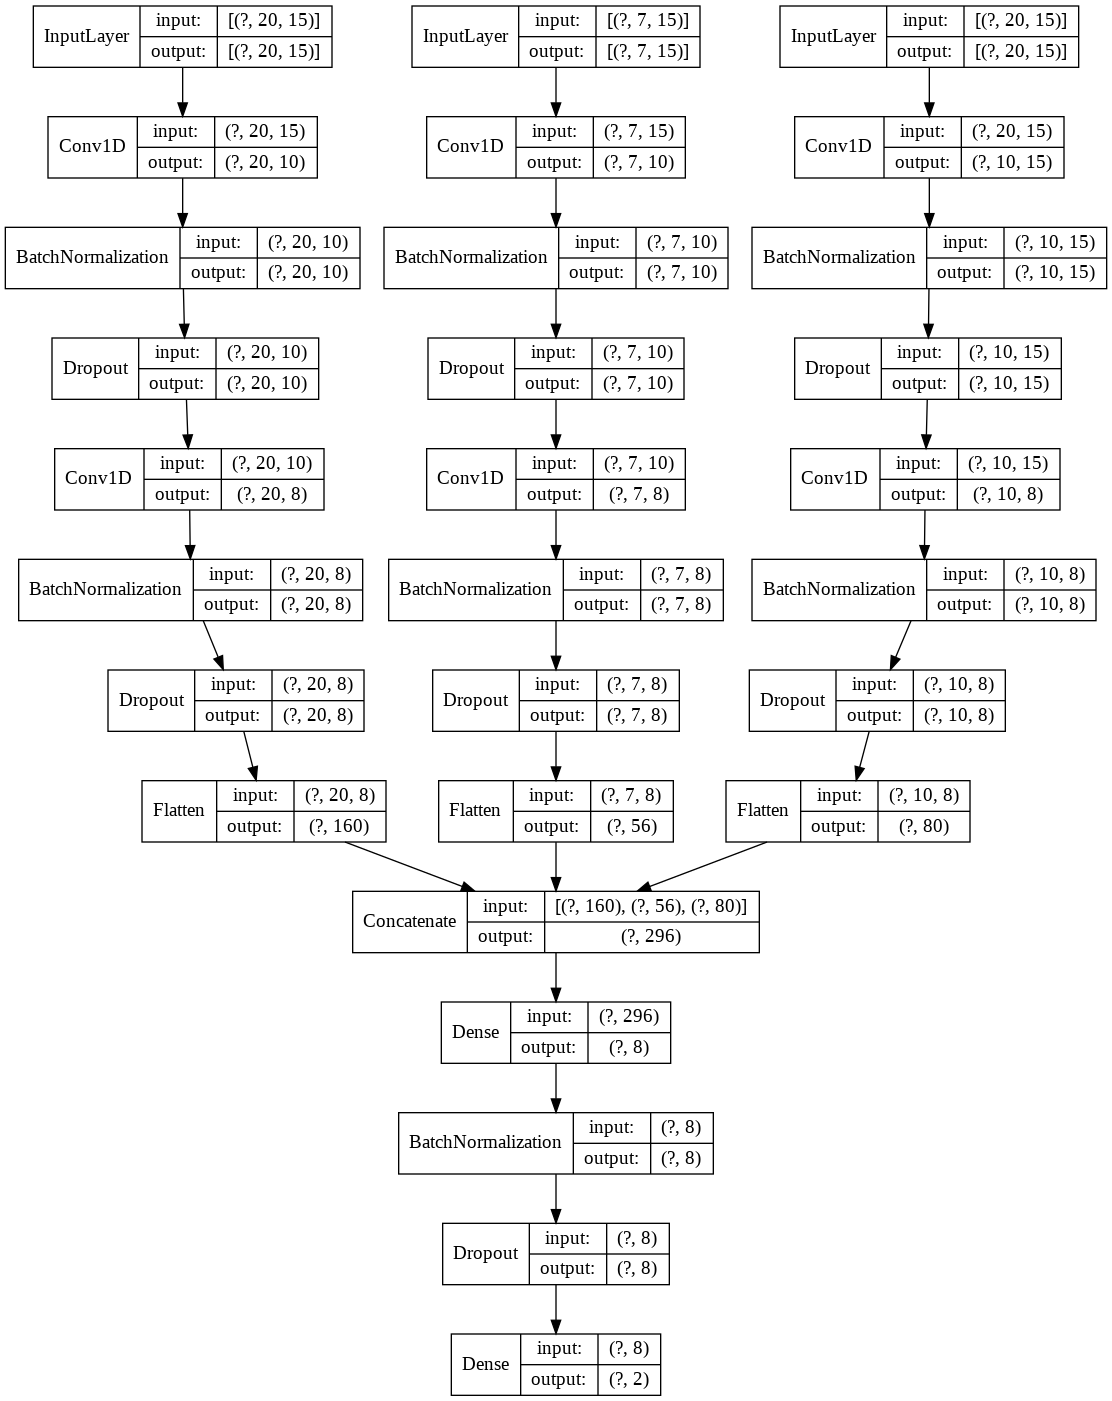

In [79]:
model = Network()
model.summary()
plot_model(model, to_file='model-240.png', show_shapes=True, show_layer_names=False, expand_nested=True)

## [5]. Run Model:

Train on 192 samples, validate on 48 samples
Epoch 1/400
192/192 [==============================] - 3s 16ms/sample - loss: 1.6698 - accuracy: 0.5521 - val_loss: 1.3668 - val_accuracy: 0.5833
Epoch 2/400
192/192 [==============================] - 0s 1ms/sample - loss: 1.8145 - accuracy: 0.5260 - val_loss: 1.3429 - val_accuracy: 0.5625
Epoch 3/400
192/192 [==============================] - 0s 1ms/sample - loss: 1.7574 - accuracy: 0.4635 - val_loss: 1.3455 - val_accuracy: 0.4583
Epoch 4/400
192/192 [==============================] - 0s 1ms/sample - loss: 1.4397 - accuracy: 0.5208 - val_loss: 1.3493 - val_accuracy: 0.4583
Epoch 5/400
192/192 [==============================] - 0s 1ms/sample - loss: 1.4167 - accuracy: 0.5938 - val_loss: 1.3293 - val_accuracy: 0.4583
Epoch 6/400
192/192 [==============================] - 0s 1ms/sample - loss: 1.3066 - accuracy: 0.5938 - val_loss: 1.3080 - val_accuracy: 0.4583
Epoch 7/400
192/192 [==============================] - 0s 1ms/sample - loss: 1.2804 

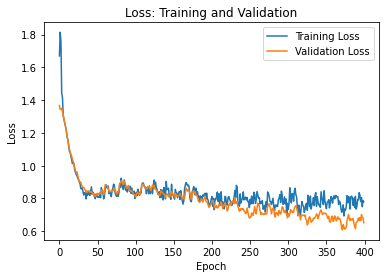

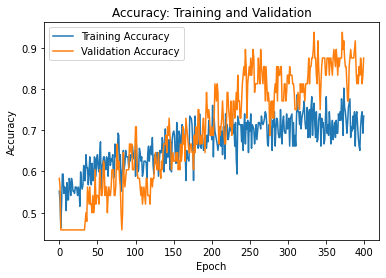

#################################################
Train on 192 samples, validate on 48 samples
Epoch 1/400
192/192 [==============================] - 2s 11ms/sample - loss: 2.1222 - accuracy: 0.5208 - val_loss: 1.2929 - val_accuracy: 0.6250
Epoch 2/400
192/192 [==============================] - 0s 1ms/sample - loss: 1.9440 - accuracy: 0.4583 - val_loss: 1.3092 - val_accuracy: 0.5833
Epoch 3/400
192/192 [==============================] - 0s 1ms/sample - loss: 1.6579 - accuracy: 0.5312 - val_loss: 1.3287 - val_accuracy: 0.5625
Epoch 4/400
192/192 [==============================] - 0s 1ms/sample - loss: 1.5321 - accuracy: 0.5312 - val_loss: 1.3426 - val_accuracy: 0.5208
Epoch 5/400
192/192 [==============================] - 0s 993us/sample - loss: 1.4936 - accuracy: 0.5417 - val_loss: 1.3301 - val_accuracy: 0.5208
Epoch 6/400
192/192 [==============================] - 0s 978us/sample - loss: 1.4432 - accuracy: 0.4792 - val_loss: 1.3113 - val_accuracy: 0.5833
Epoch 7/400
192/192 [=========

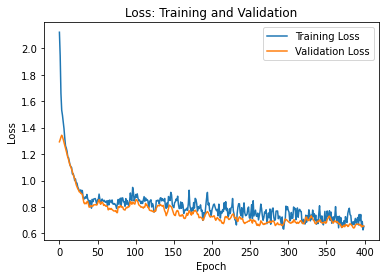

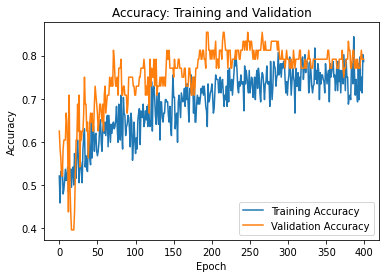

#################################################
Train on 192 samples, validate on 48 samples
Epoch 1/400
192/192 [==============================] - 2s 11ms/sample - loss: 2.0883 - accuracy: 0.5365 - val_loss: 1.3858 - val_accuracy: 0.6042
Epoch 2/400
192/192 [==============================] - 0s 1ms/sample - loss: 1.7971 - accuracy: 0.5417 - val_loss: 1.3584 - val_accuracy: 0.5000
Epoch 3/400
192/192 [==============================] - 0s 918us/sample - loss: 1.6991 - accuracy: 0.5260 - val_loss: 1.3496 - val_accuracy: 0.6042
Epoch 4/400
192/192 [==============================] - 0s 883us/sample - loss: 1.5426 - accuracy: 0.5000 - val_loss: 1.3405 - val_accuracy: 0.6042
Epoch 5/400
192/192 [==============================] - 0s 912us/sample - loss: 1.3971 - accuracy: 0.5573 - val_loss: 1.3287 - val_accuracy: 0.5000
Epoch 6/400
192/192 [==============================] - 0s 1ms/sample - loss: 1.3128 - accuracy: 0.6094 - val_loss: 1.3125 - val_accuracy: 0.5000
Epoch 7/400
192/192 [=======

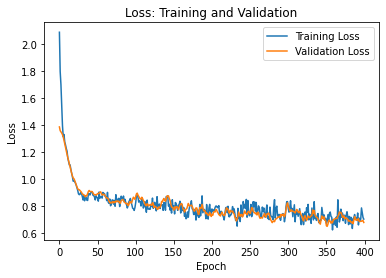

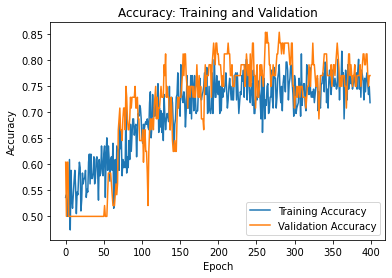

#################################################
Train on 192 samples, validate on 48 samples
Epoch 1/400
192/192 [==============================] - 2s 11ms/sample - loss: 1.8457 - accuracy: 0.5104 - val_loss: 1.3898 - val_accuracy: 0.5625
Epoch 2/400
192/192 [==============================] - 0s 1ms/sample - loss: 2.0568 - accuracy: 0.4635 - val_loss: 1.3866 - val_accuracy: 0.5000
Epoch 3/400
192/192 [==============================] - 0s 928us/sample - loss: 1.6861 - accuracy: 0.5156 - val_loss: 1.3841 - val_accuracy: 0.5000
Epoch 4/400
192/192 [==============================] - 0s 851us/sample - loss: 1.5344 - accuracy: 0.5521 - val_loss: 1.3789 - val_accuracy: 0.5000
Epoch 5/400
192/192 [==============================] - 0s 904us/sample - loss: 1.5353 - accuracy: 0.4635 - val_loss: 1.3646 - val_accuracy: 0.5208
Epoch 6/400
192/192 [==============================] - 0s 1ms/sample - loss: 1.4698 - accuracy: 0.5469 - val_loss: 1.3495 - val_accuracy: 0.5208
Epoch 7/400
192/192 [=======

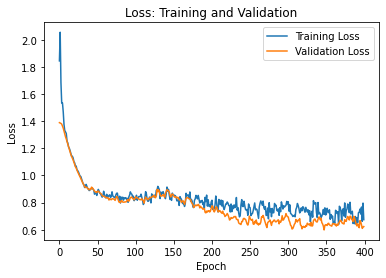

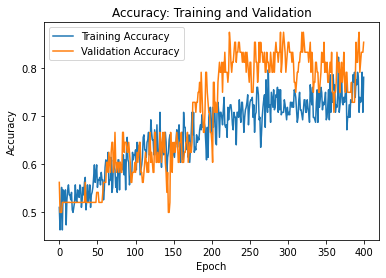

#################################################
Train on 192 samples, validate on 48 samples
Epoch 1/400
192/192 [==============================] - 2s 10ms/sample - loss: 2.2263 - accuracy: 0.5677 - val_loss: 1.3378 - val_accuracy: 0.5208
Epoch 2/400
192/192 [==============================] - 0s 1ms/sample - loss: 2.0055 - accuracy: 0.4740 - val_loss: 1.3230 - val_accuracy: 0.5833
Epoch 3/400
192/192 [==============================] - 0s 1ms/sample - loss: 2.0884 - accuracy: 0.5052 - val_loss: 1.3187 - val_accuracy: 0.5625
Epoch 4/400
192/192 [==============================] - 0s 1ms/sample - loss: 1.8643 - accuracy: 0.4896 - val_loss: 1.3356 - val_accuracy: 0.6250
Epoch 5/400
192/192 [==============================] - 0s 990us/sample - loss: 1.5695 - accuracy: 0.5000 - val_loss: 1.3503 - val_accuracy: 0.5625
Epoch 6/400
192/192 [==============================] - 0s 1ms/sample - loss: 1.5399 - accuracy: 0.4948 - val_loss: 1.3456 - val_accuracy: 0.5417
Epoch 7/400
192/192 [===========

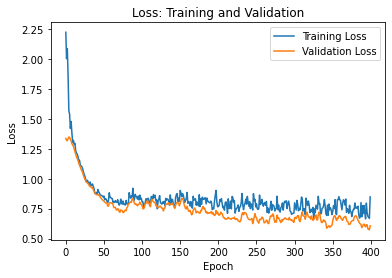

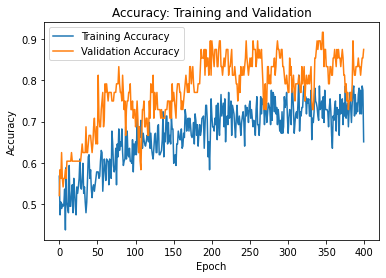

#################################################
[0.875, 0.7916667, 0.7708333, 0.8541667, 0.875]
Accuracy: 0.83
Sensitivity: 0.9005
Specificity: 0.7557
MCC: 0.6658
Precision: 0.8112


In [80]:
setEpochNumber     = 400     # 250 performed well.
setBatchSizeNumber = 8
####################################################

cv = KFold(n_splits=5, shuffle=True, random_state=101)

Accuracy = []
Sensitivity = []
Specificity = []
Precision = []
MCC = []

for train, test in cv.split(Y):

    # Compile Model:
    model = Network()
    model.compile(optimizer=Adam(learning_rate=0.005),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Run Model:
    results = model.fit(x=[X1[train,:,:], X2[train,:,:], X3[train,:,:]], y=[Y[train,:]],
                        validation_data=([X1[test,:,:], X2[test,:,:], X3[test,:,:]], [Y[test,:]]),
                        batch_size=setBatchSizeNumber, epochs=setEpochNumber, verbose=1)

    # Evaluate the Model:
    accuracy = model.evaluate(x=[X1[test,:,:], X2[test,:,:], X3[test,:,:]], y=Y[test,:], batch_size=setBatchSizeNumber)
    Accuracy.append(accuracy[1])
    
    # Performance Metices:
    Yactual = Y[test,:].argmax(axis=1)
    Yp = model.predict([X1[test,:,:], X2[test,:,:], X3[test,:,:]])
    Yp = Yp.argmax(axis=1)

    CM = confusion_matrix(y_pred=Yp, y_true=Yactual)
    TN, FP, FN, TP = CM.ravel()

    MCC.append(matthews_corrcoef(y_true=Yactual, y_pred=Yp))
    Sensitivity.append( TP / (TP + FN) )
    Specificity.append( TN / (TN + FP) )
    Precision.append(precision_score(y_true=Yactual, y_pred=Yp))
    
    
    # Performance Plot
    print('#################################################')
    print('Fold\'s Accuracy: {:.2f}'.format(accuracy[1]*100.0))
    lossPlot(results)
    accuracyPlot(results)
    print('#################################################')
#end-for

print(Accuracy)
print('Accuracy: {:.2f}'.format(np.sum(Accuracy)/5.0))
print('Sensitivity: {0:.4f}'.format(np.sum(Sensitivity)/5.00))
print('Specificity: {0:.4f}'.format(np.sum(Specificity)/5.00))
print('MCC: {0:.4f}'.format(np.sum(MCC)/5.00))
print('Precision: {0:.4f}'.format(np.sum(Precision)/5.00))